[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/multilingual/tatoeba-semantic-search-multilingual/tatoeba-semantic-search-multilingual.ipynb)

## Semantic Search for better Language Learning with Inference API and Pinecone


Multilingual embeddings make it possible to extract information across languages, without translation.

In this notebook, we'll introduce you to the [Pinecone Inference API](https://docs.pinecone.io/guides/inference/understanding-inference-api) and multilingual embeddings created by E5 by building a simple language learning search application. At the end of this notebook, you'll learn how to:

- use the Inference API to embed new data
- use the E5 model on multilingual data
- upsert and query in multilingual fashion with Pinecone


Let's get started!

**What we'll do in this Notebook:**



1.   Installation
2.   Dataset Prep
3.   Using the Inference API for Embedding
4.   Indexing into Pinecone
5.   Language Learning Semantic Search








### Installation

We'll get started by installing Pinecone and the Hugging Face datasets library, which will let us access the Tatoeba dataset.

In [ ]:
!pip install pinecone datasets

# helper for pinecone connect integrations
!pip install -qU pinecone-notebooks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.5/245.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ib

## Setting the Scene: Learning a new language!

Suppose you are learning Spanish (or English!) and want to describe your weekend trip to a local park in Spanish. You learn about a website called Tatoeba which is for language learners.


Tatoeba aims to be a place where people can learn how to say sentences in different languages really easily,
and they offer advanced keyword search to enable this capability.


You could search "park" on Tatoeba, and get back sentences that contain this word. But the word park can also be a verb in English, which may bring up sentences that are irrelevant to your learning.

We'll use semantic search to adjust these results to better bring up relevant and semantically similar sentences to your queries.


In doing so, we'll approach the problem in two ways:
- creating an index with only English text, to demonstrate the workflow
- then, we'll create an index with the spanish text, and search over it in English!


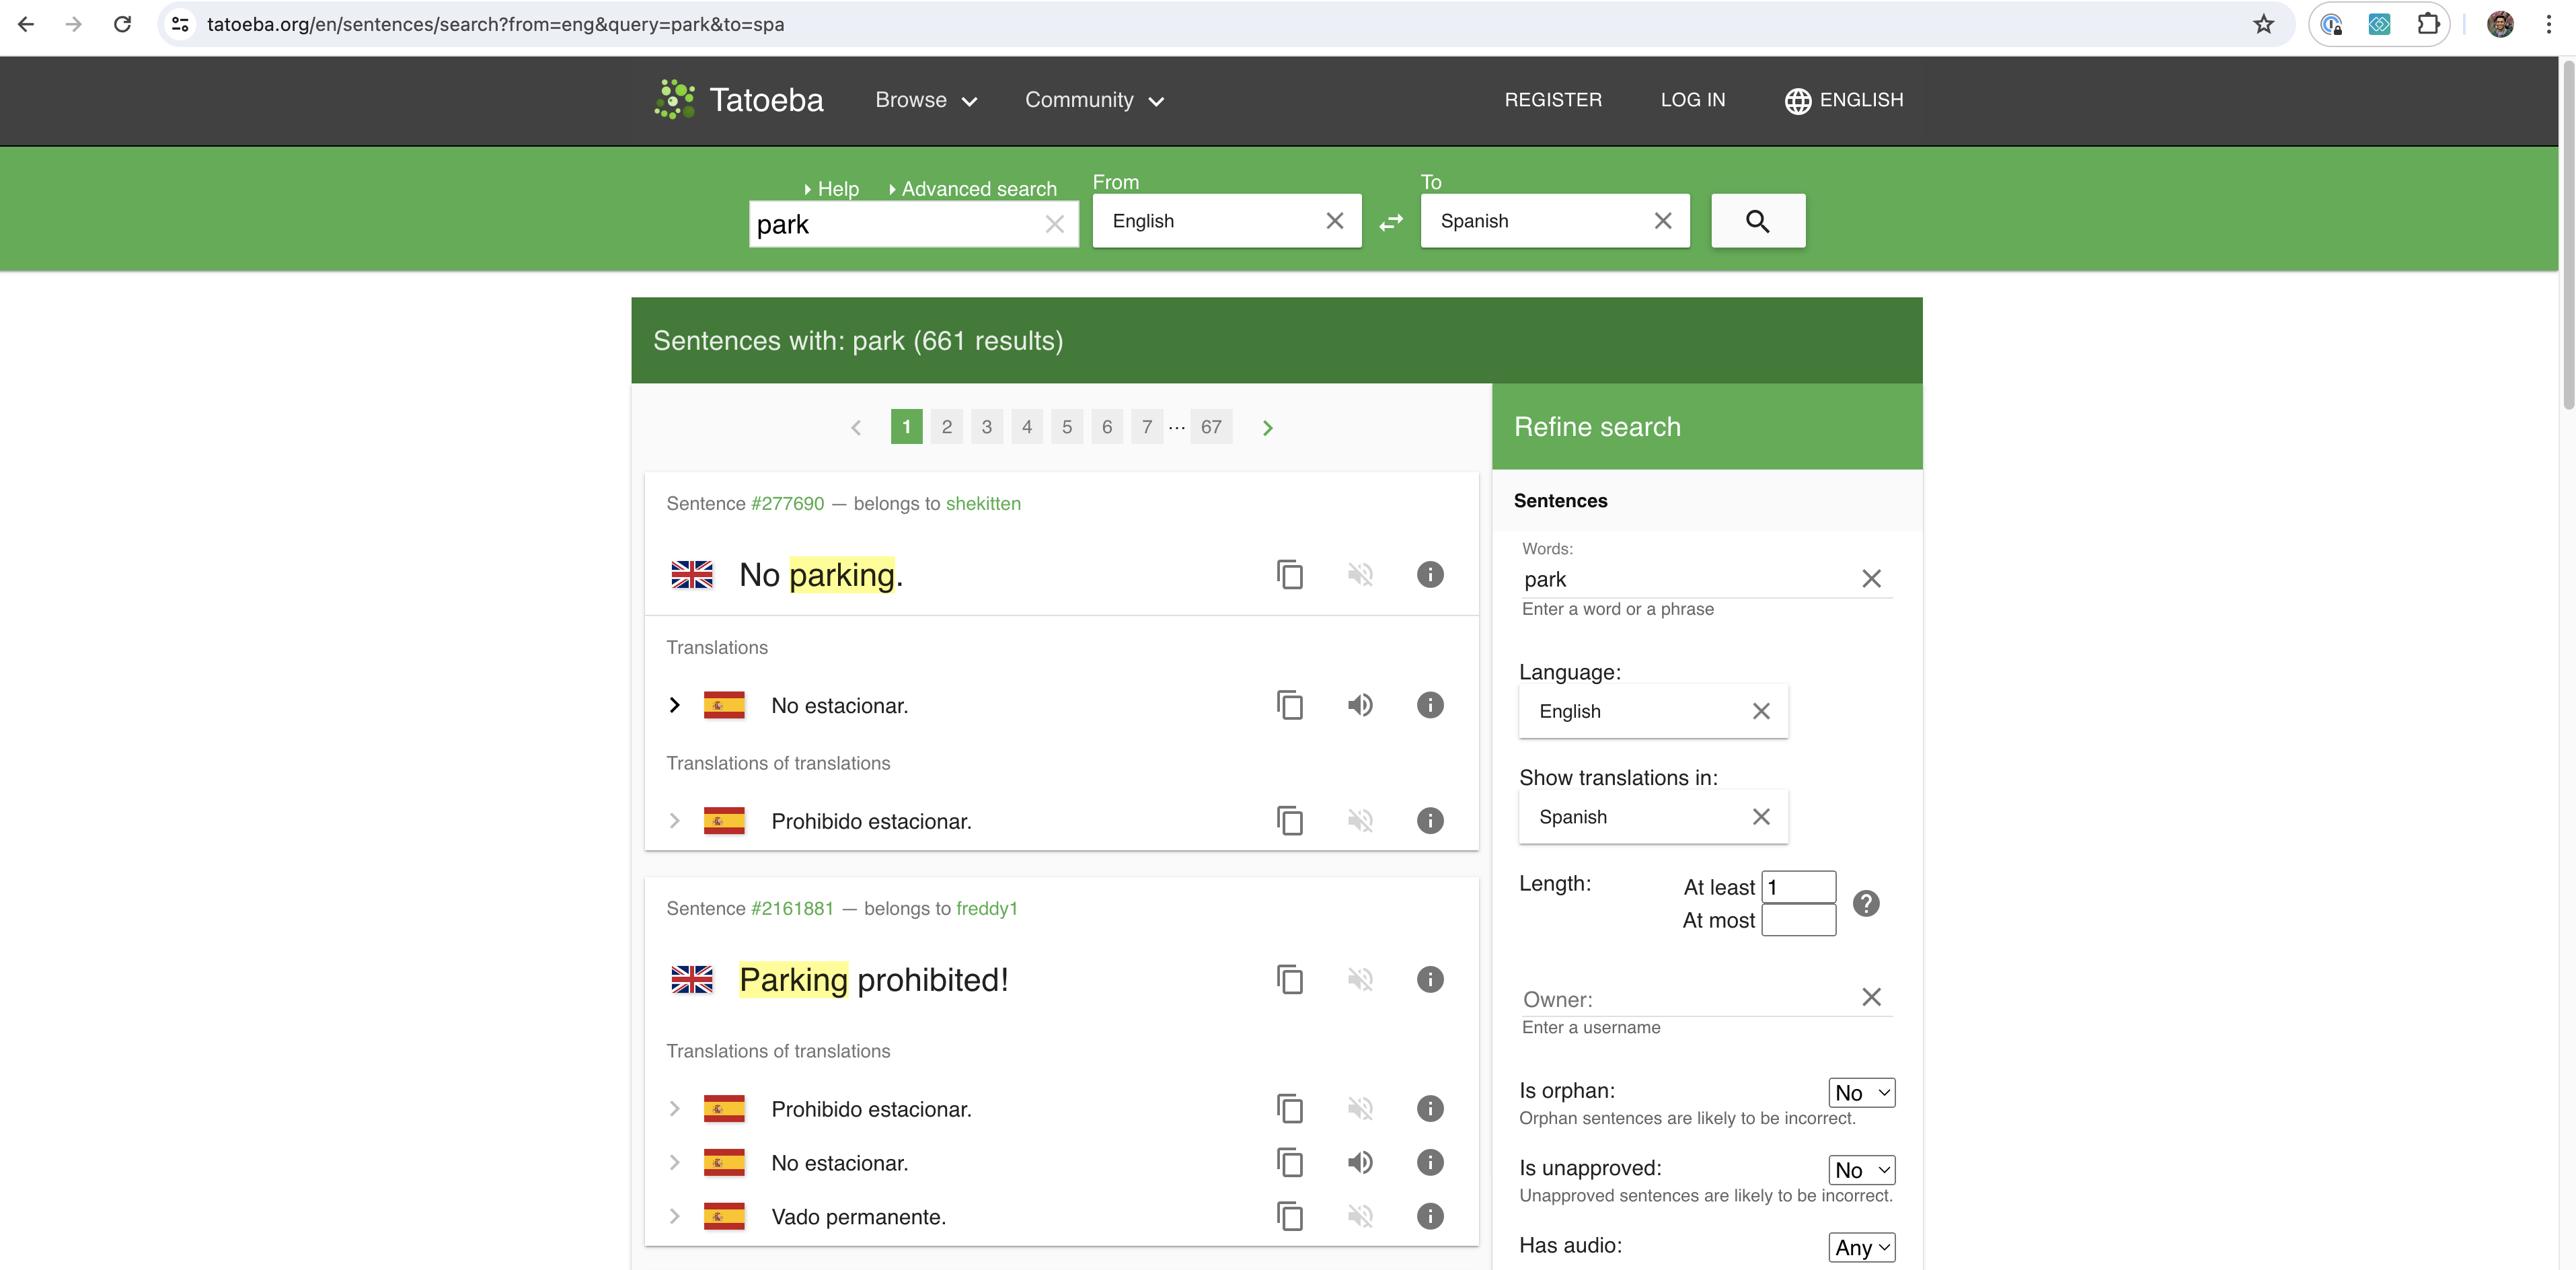

### Downloading our dataset



We'll use Helsinki-NLP's version of the Tatoeba set, hosted on Hugging Face.


Using their dataset of translation pairs in English and Spanish, we'll implement semantic search so we can not only bring up translations, but sentences that are
semantically similar and relevant for a user, allowing for easier contextual language learning.


We'll use English and Spanish translations, but the Inference API's multilingual-e5-large model is compatible with nearly 100 languages, so the possiblities for what you can build are endless!


In [ ]:
from pinecone_notebooks.colab import Authenticate

Authenticate()

In [ ]:
import os
from datasets import load_dataset

# specify that we want the english-spanish translation pairs
tatoeba = load_dataset("Helsinki-NLP/tatoeba", lang1="en", lang2="es", trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

The Tatoeba dataset consists of translated sentence pairs. We'll take advantage of this property to demonstrate the monolingual and cross-lingual capabilities of our model

In [ ]:
tatoeba["train"][0]

{'id': '0',
 'translation': {'en': "Let's try something.", 'es': '¡Intentemos algo!'}}

### Keywords as a foundation





We'll use the keyword "park" to create an artificial subset of our data. Park has several meanings in the English language, such as a verb (to park) or a noun
(play at the park). We'll take advantage of this property to demonstrate how
multilingual embeddings can differentate between these meanings.

In [ ]:
# grab sentences based on keywords

keywords = ["park"]

def simple_keyword_search(sentence, keywords):
  # filter for a list of keywords by sentence
    for keyword in keywords:
        if keyword in sentence:
            return True
    return False



# filter on english sentences
translation_pairs = tatoeba["train"].filter(lambda x: simple_keyword_search(
    sentence = x["translation"]["en"], keywords=keywords))


# flatten and shuffle for ease of use
translation_pairs = translation_pairs.flatten()
translation_pairs = translation_pairs.shuffle(seed=1)

Filter:   0%|          | 0/214127 [00:00<?, ? examples/s]

In [ ]:
translation_pairs

Dataset({
    features: ['id', 'translation.en', 'translation.es'],
    num_rows: 416
})

In [ ]:
translation_pairs[0]["translation.en"]

'When my brother was young, I often used to take him to the park.'

In [ ]:
for x in range(0, 10):
    eng_sentence = translation_pairs[x]["translation.en"]
    es_sentence = translation_pairs[x]["translation.es"]
    print(f"English sentence: {eng_sentence} Spanish Translation: {es_sentence}")

English sentence: When my brother was young, I often used to take him to the park. Spanish Translation: Cuando mi hermano era pequeño, solía llevarle al parque a menudo.
English sentence: Yumi went to the park to play tennis. Spanish Translation: Yumi se fue al parque a jugar al tenis.
English sentence: Sir, you are not allowed to park your car here. Spanish Translation: No puede estacionarse aquí.
English sentence: There were a crowd of people in the park. Spanish Translation: Había una multitud en el parque.
English sentence: There were almost no cars in the parking lot. Spanish Translation: Casi no había autos en el estacionamiento.
English sentence: Tom says we can park on either side of the street. Spanish Translation: Tom dice que podemos aparcar en los dos lados de la calle.
English sentence: I have lost my umbrella somewhere in the park. I have to buy one. Spanish Translation: Se me perdió mi paraguas en alguna parte en el parque. Tengo que comprar uno nuevo.
English sentence: 

## Setting up our Indexes

Next, we'll set up our Pinecone index and configure it with a dimensionality of 1024 to match our embedding model's output vector size.

In [ ]:
from pinecone import Pinecone, ServerlessSpec

DIMENSION = 1024
INDEX_NAME = "tatoeba-semantic-search"

pc = Pinecone(source_tag="tatoeba_semantic_search_notebook")


def create_index(index_name):

    # checks if index already exists. If it does, skip!

    if not pc.has_index(index_name):
        index = pc.create_index(
            name=index_name,
            dimension=DIMENSION,
            # this is the distance metric that E5 was trained with!
            metric="cosine",
            spec=ServerlessSpec(
                cloud='aws',
                region='us-east-1'
            )
        )
        return index


create_index(INDEX_NAME)


## Embedding with the Pinecone Inference API and E5: Queries and Passages

Fortunately for us, the multilingal-e5-large model in the Pinecone Inference API is super easy to use with multilingual data. We don't need to concern ourselves with switching languages, as the endpoint will tokenize and embed for us. However, we do need to make a distinction between queries and passages.

**Queries** are the sentences or phrases we'll want to search with, and **passages** are the sentences we'll store in Pinecone. The distinction exists because e5-multilingual-large was trained on datasets that aligned queries with longer form passages such as articles, chapters, etc. We can specify the type of string we are embedding within the inference.embed function.



In [ ]:

def embed_data(sentences):
    # given sentences, pass to Pinecone embedder and return embedding response
    embeddings = pc.inference.embed(
        model = "multilingual-e5-large",

        # must be passed as a list
        inputs = sentences,
        # can also add optional "truncate" parameter for longer passages
        # passage type, as we are doing a form of relevance search
        parameters = {"input_type": "passage"}
    )
    return embeddings


In [ ]:
translation_pairs

Dataset({
    features: ['id', 'translation.en', 'translation.es'],
    num_rows: 416
})

Let's take a quick look at our data to understand what we're working with!

In [ ]:
english_sentence = translation_pairs[0]["translation.en"]
spanish_translation = translation_pairs[0]["translation.es"]

print(english_sentence, spanish_translation)

When my brother was young, I often used to take him to the park. Cuando mi hermano era pequeño, solía llevarle al parque a menudo.


In [ ]:
en_embedding = embed_data([english_sentence])
es_embedding = embed_data([spanish_translation])

In [ ]:
en_embedding

EmbeddingsList(
  model='multilingual-e5-large',
  data=[
    {'values': [0.017303466796875, -0.0082855224609375, ..., -0.0204315185546875, -0.0007982254028320312]}
  ],
  usage={'total_tokens': 20}
)

In [ ]:
es_embedding

EmbeddingsList(
  model='multilingual-e5-large',
  data=[
    {'values': [0.0149993896484375, -0.0218353271484375, ..., -0.0209197998046875, 0.005039215087890625]}
  ],
  usage={'total_tokens': 20}
)

## Batch Embedding and Upsertion

We can combine both embedding and upserting operations! We'll need to keep in mind that the **batch size for our current model is 96.**

For simplicity, we'll batch in this size and upsert at the same time.

First, we'll do some data cleaning to make our task a bit clearer and merge our datasets.




In [ ]:

# cleaning columns for ease of use

from datasets import concatenate_datasets

english_sentences = translation_pairs.rename_column("translation.en", "text").remove_columns("translation.es")
spanish_sentences = translation_pairs.rename_column("translation.es", "text").remove_columns("translation.en")

# add lang column to indicate embedding origin
english_sentences = english_sentences.add_column("lang", ["en"]*len(english_sentences))
spanish_sentences = spanish_sentences.add_column("lang", ["es"]*len(english_sentences))


#merge dataset
all_sentences = concatenate_datasets([english_sentences, spanish_sentences])

#add id column/overwrite
all_sentences = all_sentences.remove_columns("id")
all_sentences = all_sentences.add_column("id", range(0 ,len(all_sentences)))


Flattening the indices:   0%|          | 0/416 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/416 [00:00<?, ? examples/s]

In [ ]:
all_sentences[0:5]


{'text': ['When my brother was young, I often used to take him to the park.',
  'Yumi went to the park to play tennis.',
  'Sir, you are not allowed to park your car here.',
  'There were a crowd of people in the park.',
  'There were almost no cars in the parking lot.'],
 'lang': ['en', 'en', 'en', 'en', 'en'],
 'id': [0, 1, 2, 3, 4]}

When turning the embeddings into vectors for upsertion, we'll store the text and the language the embedding corresponds to as metadata. This will make searching by language over the dataset easier.

Lucky for us, we can use [the map function](https://huggingface.co/docs/datasets/en/process#map) from the datasets library to
make batch processing painless!

The map function allows us to iterate over our dataframe in batches, on which
we can embed and upsert our data. This also means we'll only need one pass
over our data to finish processing it for our index.

Finally, we'll return the embedding as a new column in the returned dataset.


In [ ]:
embed_data(all_sentences[0:5]["text"]).data

[{'values': [0.017303466796875, -0.0082855224609375, ..., -0.0204315185546875, -0.0007982254028320312]},
 {'values': [0.01403045654296875, -0.00792694091796875, ..., -0.01126861572265625, -0.007434844970703125]},
 {'values': [0.033782958984375, -0.0380859375, ..., -0.04339599609375, 0.002239227294921875]},
 {'values': [0.04522705078125, -0.0013141632080078125, ..., -0.01456451416015625, 0.01454925537109375]},
 {'values': [0.033447265625, -0.020233154296875, ..., -0.0372314453125, -0.004901885986328125]}]

In [ ]:
BATCH_SIZE = 96


def embed_and_upsert(batch, index):

  # Given batch of data as dict from dataset.map
  # and Index to upsert with Pinecone
  # embed and upsert the batch
  # and, return the embeddings as a new column


  # embed the batch and pull the embeddings
  embeddings = embed_data(batch["text"]).data
  # reshape for easier indexing
  embeddings = [d["values"] for d in embeddings]

  # reformat into vectors, for upsertion
  vectors = []
  for i in range(0, len(embeddings)):

    id = str(batch["id"][i])
    embedding = embeddings[i]
    text = batch["text"][i]
    lang = batch["lang"][i]

    vector = {
        "id": id,
        "values": embedding,
        "metadata":{
            "text": text,
            "lang": lang,
        },
    }
    vectors.append(vector)

  # upsert # consider outputing stuff here to indicate
  index.upsert(
      vectors = vectors
  )

  # return as a new column
  return {"embeddings": embeddings}


In [ ]:
index = pc.Index(INDEX_NAME)
final_ds = all_sentences.map(lambda batch: embed_and_upsert(batch=batch, index=index),
                                           batched=True,
                                           batch_size=BATCH_SIZE)

Parameter 'function'=<function <lambda> at 0x7cabb4eca0e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [ ]:
final_ds[0]

{'text': 'When my brother was young, I often used to take him to the park.',
 'lang': 'en',
 'id': 0,
 'embeddings': [0.017303466796875,
  -0.0082855224609375,
  -0.027801513671875,
  -0.021484375,
  0.00833892822265625,
  -0.05487060546875,
  -0.0041046142578125,
  0.0406494140625,
  0.07781982421875,
  -0.0136260986328125,
  0.02691650390625,
  0.00975799560546875,
  -0.059173583984375,
  0.00798797607421875,
  0.004856109619140625,
  0.0190277099609375,
  -0.00975799560546875,
  0.04913330078125,
  0.006168365478515625,
  -0.019989013671875,
  0.0594482421875,
  -0.0294342041015625,
  -0.0450439453125,
  -0.038421630859375,
  -0.0374755859375,
  -0.04534912109375,
  -0.035858154296875,
  -0.0267181396484375,
  -0.018890380859375,
  -0.054046630859375,
  -0.00766754150390625,
  0.007450103759765625,
  -0.0384521484375,
  -0.04071044921875,
  -0.0267486572265625,
  0.042510986328125,
  0.0237274169921875,
  0.00766754150390625,
  -0.0146331787109375,
  0.0167999267578125,
  -0.0047760

## Searching in English and Spanish for similar sentences



Now that we have upserted our data, we can use the same pipeline to embed queries to the model and search!

We'll do English-English search as a way to understand the output first.

In [ ]:

def embed_query(sentence):
  # this time, we embed the queries as "query" type

    embeddings = pc.inference.embed(
        model = "multilingual-e5-large",
        # must be passed as a list
        inputs = [sentence],
        parameters = {"input_type": "query"}
    )

    # this allows us to pull out the vector values
    return embeddings.data[0]["values"]


query_vector = embed_query("playing a sport at the park")


# We filter on "en" to search only over the English Sentences
index.query(
    vector=query_vector,
    filter= {
      "lang": {"$eq": "en"}
    },
    include_metadata=True,
    top_k=10)


{'matches': [{'id': '413',
              'metadata': {'lang': 'en', 'text': 'I am playing in the park.'},
              'score': 0.833629489,
              'values': []},
             {'id': '368',
              'metadata': {'lang': 'en',
                           'text': 'We were playing in the park.'},
              'score': 0.821107924,
              'values': []},
             {'id': '156',
              'metadata': {'lang': 'en',
                           'text': 'We were playing in the park.'},
              'score': 0.821107924,
              'values': []},
             {'id': '122',
              'metadata': {'lang': 'en',
                           'text': 'It was fun playing in the park.'},
              'score': 0.820462883,
              'values': []},
             {'id': '389',
              'metadata': {'lang': 'en', 'text': 'The kids play in the park.'},
              'score': 0.810867846,
              'values': []},
             {'id': '136',
              'metadata'

**Switching to Spanish queries requires no additional code**!

Here, we search "I play in the park at the end of the week".

And, notice the results have no exact overlap with the translated phrase!

In [ ]:
query_vector = embed_query("Jugo en el parque en la fin de semana")

index.query(
    vector=query_vector,
    filter = {
        "lang": "en"
    },
    include_metadata=True,
    top_k=10)


{'matches': [{'id': '78',
              'metadata': {'lang': 'en',
                           'text': 'I went to the park last Sunday.'},
              'score': 0.824530661,
              'values': []},
             {'id': '32',
              'metadata': {'lang': 'en',
                           'text': 'I went to the park last Saturday.'},
              'score': 0.822012424,
              'values': []},
             {'id': '283',
              'metadata': {'lang': 'en',
                           'text': 'On Saturdays, we usually visit in this '
                                   'park.'},
              'score': 0.81381613,
              'values': []},
             {'id': '192',
              'metadata': {'lang': 'en', 'text': 'What happened in the park?'},
              'score': 0.812519372,
              'values': []},
             {'id': '19',
              'metadata': {'lang': 'en',
                           'text': "It's a good day for going to the park."},
              'score'

## Bringing it full circle: English-Spanish search




Finally, we can do our initial task: learning new Spanish sentences with English! We use the same embedding and preprocessing pipeline, taking care to specify the metadata to return semantically similar results in spanish

In [ ]:
query_vector = embed_query("I went to the park last weekend to play sports")


index.query(
    vector=query_vector,
    filter = {
        "lang":"es"
    },
    include_metadata=True,
    top_k=10)


{'matches': [{'id': '448',
              'metadata': {'lang': 'es',
                           'text': 'Fui al parque el sábado pasado.'},
              'score': 0.835433,
              'values': []},
             {'id': '494',
              'metadata': {'lang': 'es',
                           'text': 'Fui al parque el domingo pasado.'},
              'score': 0.826080561,
              'values': []},
             {'id': '511',
              'metadata': {'lang': 'es',
                           'text': 'Fui al parque a darme un paseo.'},
              'score': 0.82015,
              'values': []},
             {'id': '703',
              'metadata': {'lang': 'es', 'text': 'Ayer fui al parque.'},
              'score': 0.812328279,
              'values': []},
             {'id': '809',
              'metadata': {'lang': 'es',
                           'text': 'Ayer fuiste al parque, ¿verdad?'},
              'score': 0.807226837,
              'values': []},
             {'id': '446'

And just to confirm, let's see what happens when we use the other meaning of "park"!

In [ ]:
query_vector = embed_query("I need to find a place to park")


index.query(
    vector=query_vector,
    filter={
        "lang":"es"
    },
    include_metadata=True,
    top_k=10)

{'matches': [{'id': '493',
              'metadata': {'lang': 'es', 'text': '¿Dónde puedo aparcar?'},
              'score': 0.840159774,
              'values': []},
             {'id': '649',
              'metadata': {'lang': 'es',
                           'text': 'No encuentro un lugar para estacionar mi '
                                   'nave espacial.'},
              'score': 0.838665545,
              'values': []},
             {'id': '645',
              'metadata': {'lang': 'es', 'text': '¿Dónde puedo estacionar?'},
              'score': 0.837124407,
              'values': []},
             {'id': '620',
              'metadata': {'lang': 'es',
                           'text': 'No encuentro dónde parquear mi nave '
                                   'espacial.'},
              'score': 0.836103082,
              'values': []},
             {'id': '570',
              'metadata': {'lang': 'es',
                           'text': 'Tuvo un problema al estacionar.'},
  

The result contains sentences about parking cars, which is much different than our prior query!

As we can see, there is no translation happening here, as the only English sentence being used is the query. Somehow, the embedding model captures the meaning of these sentences across languages. That's magical!

Try doing the following next:
- expanding the search over a larger subset of the data (be sure to be mindful of embedding and upsertion rate limits!
- test with a different language pair
- incoporating more languages within the same namespace, and see what turns up!



In [ ]:
pc.delete_index("tatoeba-semantic-search")